# Model Training & Evaluation Notebook
## Multiclass Aggression Detection: Complete Training Pipeline

**Models trained:**
1. Logistic Regression (baseline)
2. SVM Linear (baseline)
3. SVM RBF (baseline)
4. BERT (state-of-the-art)
5. RoBERTa (state-of-the-art)

**Class weight handling:** Automatic balancing for imbalanced classes

## CELL 1: Setup & Imports

In [ ]:
import pandas as pd
import numpy as np
import torch
import warnings
warnings.filterwarnings('ignore')

import random
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import json
from datetime import datetime
from tqdm import tqdm
from scipy.special import softmax  # added: convert logits/decision scores to probabilities

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("="*80)
print("MODEL TRAINING - MULTICLASS AGGRESSION DETECTION")
print("="*80)
print(f"\n✓ CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
print(f"✓ Random Seed: {SEED}")

MODEL TRAINING - MULTICLASS AGGRESSION DETECTION

✓ CUDA Available: True
✓ GPU: Tesla T4
✓ Random Seed: 42


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader
import json


## CELL 2: Load Processed Data

In [ ]:
print("\n" + "="*80)
print("LOADING PROCESSED DATA")
print("="*80)

# Robust loader: try Colab paths first, then local
def try_np_load(colab_path, local_path):
    try:
        return np.load(colab_path)
    except Exception:
        return np.load(local_path)

try:
    X_train = try_np_load('/content/X_train_features.npy', 'X_train_features.npy')
    X_val = try_np_load('/content/X_val_features.npy', 'X_val_features.npy')
    X_test = try_np_load('/content/X_test_features.npy', 'X_test_features.npy')

    y_train = try_np_load('/content/y_train.npy', 'y_train.npy')
    y_val = try_np_load('/content/y_val.npy', 'y_val.npy')
    y_test = try_np_load('/content/y_test.npy', 'y_test.npy')

    # CSV fallbacks
    try:
        train_df = pd.read_csv('/content/train.csv')
    except Exception:
        train_df = pd.read_csv('train.csv')
    try:
        val_df = pd.read_csv('/content/val.csv')
    except Exception:
        val_df = pd.read_csv('val.csv')
    try:
        test_df = pd.read_csv('/content/test.csv')
    except Exception:
        test_df = pd.read_csv('test.csv')

    train_texts = train_df['text'].values
    val_texts = val_df['text'].values
    test_texts = test_df['text'].values

    print(f"\n✓ Features loaded:")
    print(f"  Train: {X_train.shape}")
    print(f"  Val: {X_val.shape}")
    print(f"  Test: {X_test.shape}")
    print(f"\n✓ Text loaded:")
    print(f"  Train: {len(train_texts)} samples")
    print(f"  Val: {len(val_texts)} samples")
    print(f"  Test: {len(test_texts)} samples")

    # Class distribution
    print(f"\n✓ Class distribution (Train):")
    unique, counts = np.unique(y_train, return_counts=True)
    class_names = {0: 'No Aggression', 1: 'Violence', 2: 'Gender', 3: 'Religion', 4: 'Ethnicity'}
    for cls, count in zip(unique, counts):
        print(f"  {class_names[cls]:20s}: {count:6d} ({count/len(y_train)*100:5.1f}%)")

except Exception as e:
    raise FileNotFoundError("Could not load dataset files: ensure .npy and .csv files exist in working directory") from e


LOADING PROCESSED DATA

✓ Features loaded:
  Train: (13997, 5023)
  Val: (2000, 5023)
  Test: (4000, 5023)

✓ Text loaded:
  Train: 13997 samples
  Val: 2000 samples
  Test: 4000 samples

✓ Class distribution (Train):
  No Aggression       :   4686 ( 33.5%)
  Violence            :   3774 ( 27.0%)
  Gender              :   3975 ( 28.4%)
  Religion            :    573 (  4.1%)
  Ethnicity           :    989 (  7.1%)


## CELL 3: Calculate Class Weights for Imbalanced Data

**Important:** Using `class_weight='balanced'` handles class imbalance automatically!

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

print("\n" + "="*80)
print("CLASS WEIGHT CALCULATION FOR IMBALANCED DATA")
print("="*80)

# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {i: w for i, w in enumerate(class_weights)}

print("\nClass Weights (how much to penalize misclassification):")
print("\nClass                Weight    Interpretation")
print("-" * 60)
for cls, weight in class_weight_dict.items():
    print(f"{class_names[cls]:20s} {weight:8.4f}  (minority × {weight:.2f})")

print("\nHow this works:")
print("-" * 60)
print("Loss = sum(class_weight[y] * loss_per_sample)")
print("")
print("Minority classes (Religion, Ethnicity):")
print("  → Get higher weights → Misclassifying them is more costly")
print("  → Model learns to pay more attention to them")
print("")
print("Majority classes (No Aggression, Violence):")
print("  → Get lower weights → Standard penalty")
print("  → Prevents overfitting to majority")

# For transformers - torch format
class_weights_torch = torch.tensor(class_weights, dtype=torch.float32)
print(f"\n✓ Class weights for PyTorch: {class_weights_torch}")


CLASS WEIGHT CALCULATION FOR IMBALANCED DATA

Class Weights (how much to penalize misclassification):

Class                Weight    Interpretation
------------------------------------------------------------
No Aggression          0.5974  (minority × 0.60)
Violence               0.7418  (minority × 0.74)
Gender                 0.7043  (minority × 0.70)
Religion               4.8855  (minority × 4.89)
Ethnicity              2.8305  (minority × 2.83)

How this works:
------------------------------------------------------------
Loss = sum(class_weight[y] * loss_per_sample)

Minority classes (Religion, Ethnicity):
  → Get higher weights → Misclassifying them is more costly
  → Model learns to pay more attention to them

Majority classes (No Aggression, Violence):
  → Get lower weights → Standard penalty
  → Prevents overfitting to majority

✓ Class weights for PyTorch: tensor([0.5974, 0.7418, 0.7043, 4.8855, 2.8305])


## CELL 4: Logistic Regression with Class Weights

In [ ]:
print("\n" + "="*80)
print("MODEL 1: LOGISTIC REGRESSION (with class_weight='balanced')")
print("="*80)

print("\nTraining Logistic Regression...")

lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # ✅ AUTOMATIC CLASS WEIGHT BALANCING
    solver='lbfgs',
    multi_class='multinomial',
    random_state=SEED,
    verbose=1
)

lr_model.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test)

# Calculate metrics
lr_results = {
    'model': 'Logistic Regression',
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'f1_weighted': f1_score(y_test, y_pred_lr, average='weighted'),
    'f1_macro': f1_score(y_test, y_pred_lr, average='macro'),
    'precision': precision_score(y_test, y_pred_lr, average='weighted'),
    'recall': recall_score(y_test, y_pred_lr, average='weighted'),
}

print(f"\n✓ Results:")
print(f"  Accuracy:     {lr_results['accuracy']:.4f}")
print(f"  F1 (weighted): {lr_results['f1_weighted']:.4f}")
print(f"  F1 (macro):    {lr_results['f1_macro']:.4f}")
print(f"  Precision:     {lr_results['precision']:.4f}")
print(f"  Recall:        {lr_results['recall']:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=list(class_names.values())))


MODEL 1: LOGISTIC REGRESSION (with class_weight='balanced')

Training Logistic Regression...

✓ Results:
  Accuracy:     0.6947
  F1 (weighted): 0.6942
  F1 (macro):    0.6677
  Precision:     0.6945
  Recall:        0.6947

Classification Report:
               precision    recall  f1-score   support

No Aggression       0.66      0.67      0.67      1339
     Violence       0.70      0.71      0.71      1079
       Gender       0.75      0.75      0.75      1136
     Religion       0.66      0.53      0.59       164
    Ethnicity       0.66      0.60      0.63       282

     accuracy                           0.69      4000
    macro avg       0.69      0.65      0.67      4000
 weighted avg       0.69      0.69      0.69      4000



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.4s finished


## CELL 5: SVM Linear with Class Weights

In [ ]:
print("\n" + "="*80)
print("MODEL 2: SVM LINEAR (with class_weight='balanced')")
print("="*80)

print("\nTraining SVM (Linear kernel)...")

svm_linear = SVC(
    kernel='linear',
    C=1.0,
    class_weight='balanced',  # ✅ AUTOMATIC CLASS WEIGHT BALANCING
    random_state=SEED,
    verbose=1
)

svm_linear.fit(X_train, y_train)

# Predict
y_pred_svm_linear = svm_linear.predict(X_test)

svm_linear_results = {
    'model': 'SVM (Linear)',
    'accuracy': accuracy_score(y_test, y_pred_svm_linear),
    'f1_weighted': f1_score(y_test, y_pred_svm_linear, average='weighted'),
    'f1_macro': f1_score(y_test, y_pred_svm_linear, average='macro'),
    'precision': precision_score(y_test, y_pred_svm_linear, average='weighted'),
    'recall': recall_score(y_test, y_pred_svm_linear, average='weighted'),
}

print(f"\n✓ Results:")
print(f"  Accuracy:     {svm_linear_results['accuracy']:.4f}")
print(f"  F1 (weighted): {svm_linear_results['f1_weighted']:.4f}")
print(f"  F1 (macro):    {svm_linear_results['f1_macro']:.4f}")
print(f"  Precision:     {svm_linear_results['precision']:.4f}")
print(f"  Recall:        {svm_linear_results['recall']:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_svm_linear, target_names=list(class_names.values())))


MODEL 2: SVM LINEAR (with class_weight='balanced')

Training SVM (Linear kernel)...
[LibSVM]
✓ Results:
  Accuracy:     0.6823
  F1 (weighted): 0.6828
  F1 (macro):    0.6524
  Precision:     0.6935
  Recall:        0.6823

Classification Report:
               precision    recall  f1-score   support

No Aggression       0.59      0.72      0.65      1339
     Violence       0.69      0.68      0.68      1079
       Gender       0.80      0.72      0.76      1136
     Religion       0.78      0.45      0.57       164
    Ethnicity       0.69      0.54      0.61       282

     accuracy                           0.68      4000
    macro avg       0.71      0.62      0.65      4000
 weighted avg       0.69      0.68      0.68      4000



## CELL 6: SVM RBF with Class Weights

In [ ]:
print("\n" + "="*80)
print("MODEL 3: SVM RBF (with class_weight='balanced')")
print("="*80)

print("\nTraining SVM (RBF kernel) - this may take several minutes...")

svm_rbf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',  # ✅ AUTOMATIC CLASS WEIGHT BALANCING
    random_state=SEED,
    verbose=1
)

svm_rbf.fit(X_train, y_train)

# Predict
y_pred_svm_rbf = svm_rbf.predict(X_test)

svm_rbf_results = {
    'model': 'SVM (RBF)',
    'accuracy': accuracy_score(y_test, y_pred_svm_rbf),
    'f1_weighted': f1_score(y_test, y_pred_svm_rbf, average='weighted'),
    'f1_macro': f1_score(y_test, y_pred_svm_rbf, average='macro'),
    'precision': precision_score(y_test, y_pred_svm_rbf, average='weighted'),
    'recall': recall_score(y_test, y_pred_svm_rbf, average='weighted'),
}

print(f"\n✓ Results:")
print(f"  Accuracy:     {svm_rbf_results['accuracy']:.4f}")
print(f"  F1 (weighted): {svm_rbf_results['f1_weighted']:.4f}")
print(f"  F1 (macro):    {svm_rbf_results['f1_macro']:.4f}")
print(f"  Precision:     {svm_rbf_results['precision']:.4f}")
print(f"  Recall:        {svm_rbf_results['recall']:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_svm_rbf, target_names=list(class_names.values())))


MODEL 3: SVM RBF (with class_weight='balanced')

Training SVM (RBF kernel) - this may take several minutes...
[LibSVM]
✓ Results:
  Accuracy:     0.7035
  F1 (weighted): 0.6984
  F1 (macro):    0.6287
  Precision:     0.7147
  Recall:        0.7035

Classification Report:
               precision    recall  f1-score   support

No Aggression       0.71      0.69      0.70      1339
     Violence       0.62      0.82      0.71      1079
       Gender       0.80      0.72      0.76      1136
     Religion       0.77      0.28      0.41       164
    Ethnicity       0.71      0.46      0.56       282

     accuracy                           0.70      4000
    macro avg       0.72      0.60      0.63      4000
 weighted avg       0.71      0.70      0.70      4000



In [ ]:

print("\nSaving SVM predictions for visualization...")

# ✅ SAVE PREDICTIONS FOR CONFUSION MATRIX
np.save('y_pred_svm_rbf.npy', y_pred_svm_rbf)

print("✓ Saved: y_pred_svm_rbf.npy")


Saving SVM predictions for visualization...
✓ Saved: y_pred_svm_rbf.npy


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Predict on test set for Logistic Regression
y_pred_lr = lr_model.predict(X_test)

# Calculate metrics for Logistic Regression
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
cm_lr = confusion_matrix(y_test, y_pred_lr)

print("Logistic Regression Test Results:")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-Score: {f1_lr:.4f}")
print("Confusion Matrix:")
print(cm_lr)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=list(class_names.values())))

# Predict on test set for SVM Linear
y_pred_svm_linear = svm_linear.predict(X_test)

# Calculate metrics for SVM Linear
accuracy_svm_linear = accuracy_score(y_test, y_pred_svm_linear)
precision_svm_linear = precision_score(y_test, y_pred_svm_linear, average='weighted')
recall_svm_linear = recall_score(y_test, y_pred_svm_linear, average='weighted')
f1_svm_linear = f1_score(y_test, y_pred_svm_linear, average='weighted')
cm_svm_linear = confusion_matrix(y_test, y_pred_svm_linear)

print("\nSVM Linear Test Results:")
print(f"Accuracy: {accuracy_svm_linear:.4f}")
print(f"Precision: {precision_svm_linear:.4f}")
print(f"Recall: {recall_svm_linear:.4f}")
print(f"F1-Score: {f1_svm_linear:.4f}")
print("Confusion Matrix:")
print(cm_svm_linear)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm_linear, target_names=list(class_names.values())))

# Predict on test set for SVM RBF
y_pred_svm_rbf = svm_rbf.predict(X_test)

# Calculate metrics for SVM RBF
accuracy_svm_rbf = accuracy_score(y_test, y_pred_svm_rbf)
precision_svm_rbf = precision_score(y_test, y_pred_svm_rbf, average='weighted')
recall_svm_rbf = recall_score(y_test, y_pred_svm_rbf, average='weighted')
f1_svm_rbf = f1_score(y_test, y_pred_svm_rbf, average='weighted')
cm_svm_rbf = confusion_matrix(y_test, y_pred_svm_rbf)

print("\nSVM RBF Test Results:")
print(f"Accuracy: {accuracy_svm_rbf:.4f}")
print(f"Precision: {precision_svm_rbf:.4f}")
print(f"Recall: {recall_svm_rbf:.4f}")
print(f"F1-Score: {f1_svm_rbf:.4f}")
print("Confusion Matrix:")
print(cm_svm_rbf)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm_rbf, target_names=list(class_names.values())))


Logistic Regression Test Results:
Accuracy: 0.6947
Precision: 0.6945
Recall: 0.6947
F1-Score: 0.6942
Confusion Matrix:
[[903 190 163  28  55]
 [186 771 105   9   8]
 [168  98 849   4  17]
 [ 42  22   7  87   6]
 [ 73  23  14   3 169]]

Classification Report:
               precision    recall  f1-score   support

No Aggression       0.66      0.67      0.67      1339
     Violence       0.70      0.71      0.71      1079
       Gender       0.75      0.75      0.75      1136
     Religion       0.66      0.53      0.59       164
    Ethnicity       0.66      0.60      0.63       282

     accuracy                           0.69      4000
    macro avg       0.69      0.65      0.67      4000
 weighted avg       0.69      0.69      0.69      4000


SVM Linear Test Results:
Accuracy: 0.6823
Precision: 0.6935
Recall: 0.6823
F1-Score: 0.6828
Confusion Matrix:
[[959 188 116  19  57]
 [276 729  72   1   1]
 [216  99 816   0   5]
 [ 66  16   4  73   5]
 [ 96  20  13   1 152]]

Classification 

## CELL 7: BERT Fine-tuning (with class weights)

In [ ]:
from transformers import Trainer
from torch.nn import CrossEntropyLoss
import json

# ✅ CUSTOM TRAINER WITH LOSS HISTORY TRACKING
class VisualizationTrainer(Trainer):
    """Trainer that tracks and saves loss history during training."""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Initialize loss history dictionaries
        self.train_losses = {}
        self.val_losses = {}
        self.epoch_losses = []

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """Compute weighted loss for imbalanced classes."""
        labels = inputs.pop('labels')
        outputs = model(**inputs)

        # Use weighted loss for imbalanced classes
        loss_fct = CrossEntropyLoss(weight=class_weights_torch.to(model.device))
        loss = loss_fct(outputs.logits, labels)

        return (loss, outputs) if return_outputs else loss

    def log(self, logs, *args, **kwargs):
        super().log(logs, *args, **kwargs)

        if 'loss' in logs:
            step = logs.get('step', 0)
            self.train_losses[step] = logs['loss']

        if 'eval_loss' in logs:
            epoch = logs.get('epoch', 0)
            self.val_losses[epoch] = logs['eval_loss']

            # Get last training loss from current epoch
            last_train_loss = list(self.train_losses.values())[-1] if self.train_losses else None

            self.epoch_losses.append({
                'epoch': epoch,
                'train_loss': last_train_loss,  # Use last captured training loss
                'val_loss': logs['eval_loss']
            })


    def get_loss_history(self):
        """Return training and validation loss history."""
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'epoch_summary': self.epoch_losses
        }

print("✓ VisualizationTrainer class defined")

✓ VisualizationTrainer class defined


In [ ]:
print("\n" + "="*80)
print("MODEL 4: BERT FINE-TUNING (with loss tracking)")
print("="*80)

print("\nPreparing BERT dataset...")

# Tokenize
tokenizer_bert = AutoTokenizer.from_pretrained('bert-base-uncased')

train_encodings_bert = tokenizer_bert(
    list(train_texts),
    truncation=True,
    padding=True,
    max_length=512
)

val_encodings_bert = tokenizer_bert(
    list(val_texts),
    truncation=True,
    padding=True,
    max_length=512
)

test_encodings_bert = tokenizer_bert(
    list(test_texts),
    truncation=True,
    padding=True,
    max_length=512
)

# Create datasets
train_dataset_bert = Dataset.from_dict({
    'input_ids': train_encodings_bert['input_ids'],
    'attention_mask': train_encodings_bert['attention_mask'],
    'labels': y_train
})

val_dataset_bert = Dataset.from_dict({
    'input_ids': val_encodings_bert['input_ids'],
    'attention_mask': val_encodings_bert['attention_mask'],
    'labels': y_val
})

test_dataset_bert = Dataset.from_dict({
    'input_ids': test_encodings_bert['input_ids'],
    'attention_mask': test_encodings_bert['attention_mask'],
    'labels': y_test
})

print(f"✓ Datasets prepared (train: {len(train_dataset_bert)}, val: {len(val_dataset_bert)}, test: {len(test_dataset_bert)})")

print("\nLoading BERT model...")

model_bert = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=5
)

print("Training BERT - this will take 30-60 minutes on GPU...\n")

training_args_bert = TrainingArguments(
    output_dir='./models/bert_model',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=100,  # ✅ IMPORTANT: Log every 100 steps
    logging_dir='./logs/bert',
    seed=SEED,
)

# ✅ USE VisualizationTrainer INSTEAD OF Trainer
trainer_bert = VisualizationTrainer(
    model=model_bert,
    args=training_args_bert,
    train_dataset=train_dataset_bert,
    eval_dataset=val_dataset_bert,
)

# Train and capture loss history
trainer_bert.train()

# ✅ EXTRACT LOSS HISTORY
bert_loss_history = trainer_bert.get_loss_history()

# Save loss history for later use
with open('bert_loss_history.json', 'w') as f:
    json.dump(bert_loss_history, f, indent=2)

print("✓ Saved: bert_loss_history.json")

print("\nEvaluating BERT on test set...")

predictions_bert = trainer_bert.predict(test_dataset_bert)
y_pred_bert = np.argmax(predictions_bert.predictions, axis=1)

# ✅ SAVE PREDICTIONS FOR CONFUSION MATRIX
np.save('y_pred_bert.npy', y_pred_bert)

bert_results = {
    'model': 'BERT',
    'accuracy': accuracy_score(y_test, y_pred_bert),
    'f1_weighted': f1_score(y_test, y_pred_bert, average='weighted'),
    'f1_macro': f1_score(y_test, y_pred_bert, average='macro'),
    'precision': precision_score(y_test, y_pred_bert, average='weighted'),
    'recall': recall_score(y_test, y_pred_bert, average='weighted'),
}

print(f"\n✓ Results:")
print(f"  Accuracy:     {bert_results['accuracy']:.4f}")
print(f"  F1 (weighted): {bert_results['f1_weighted']:.4f}")
print(f"  F1 (macro):    {bert_results['f1_macro']:.4f}")
print(f"  Precision:     {bert_results['precision']:.4f}")
print(f"  Recall:        {bert_results['recall']:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_bert, target_names=list(class_names.values())))


MODEL 4: BERT FINE-TUNING (with loss tracking)

Preparing BERT dataset...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✓ Datasets prepared (train: 13997, val: 2000, test: 4000)

Loading BERT model...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT - this will take 30-60 minutes on GPU...



wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: iam-papon2 (iam-papon2-university-of-asia-pacific-uap) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.352600,0.310723
2,0.235600,0.299117
3,0.157800,0.314201


✓ Saved: bert_loss_history.json

Evaluating BERT on test set...



✓ Results:
  Accuracy:     0.9205
  F1 (weighted): 0.9202
  F1 (macro):    0.9250
  Precision:     0.9216
  Recall:        0.9205

Classification Report:
               precision    recall  f1-score   support

No Aggression       0.93      0.86      0.90      1339
     Violence       0.88      0.96      0.92      1079
       Gender       0.94      0.95      0.95      1136
     Religion       0.93      0.96      0.94       164
    Ethnicity       0.92      0.92      0.92       282

     accuracy                           0.92      4000
    macro avg       0.92      0.93      0.92      4000
 weighted avg       0.92      0.92      0.92      4000



## CELL 8: RoBERTa Fine-tuning (with class weights)

In [ ]:
print("\n" + "="*80)
print("MODEL 5: RoBERTa FINE-TUNING (with loss tracking)")
print("="*80)

print("\nPreparing RoBERTa dataset...")

tokenizer_roberta = AutoTokenizer.from_pretrained('roberta-base')

train_encodings_roberta = tokenizer_roberta(
    list(train_texts),
    truncation=True,
    padding=True,
    max_length=512
)

val_encodings_roberta = tokenizer_roberta(
    list(val_texts),
    truncation=True,
    padding=True,
    max_length=512
)

test_encodings_roberta = tokenizer_roberta(
    list(test_texts),
    truncation=True,
    padding=True,
    max_length=512
)

# Create datasets
train_dataset_roberta = Dataset.from_dict({
    'input_ids': train_encodings_roberta['input_ids'],
    'attention_mask': train_encodings_roberta['attention_mask'],
    'labels': y_train
})

val_dataset_roberta = Dataset.from_dict({
    'input_ids': val_encodings_roberta['input_ids'],
    'attention_mask': val_encodings_roberta['attention_mask'],
    'labels': y_val
})

test_dataset_roberta = Dataset.from_dict({
    'input_ids': test_encodings_roberta['input_ids'],
    'attention_mask': test_encodings_roberta['attention_mask'],
    'labels': y_test
})

print(f"✓ Datasets prepared (train: {len(train_dataset_roberta)}, val: {len(val_dataset_roberta)}, test: {len(test_dataset_roberta)})")

print("\nLoading RoBERTa model...")

model_roberta = AutoModelForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=5
)

print("Training RoBERTa - this will take 30-60 minutes on GPU...\n")

training_args_roberta = TrainingArguments(
    output_dir='./models/roberta_model',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=100,  # ✅ IMPORTANT: Log every 100 steps
    logging_dir='./logs/roberta',
    seed=SEED,
)

# ✅ USE VisualizationTrainer INSTEAD OF Trainer
trainer_roberta = VisualizationTrainer(
    model=model_roberta,
    args=training_args_roberta,
    train_dataset=train_dataset_roberta,
    eval_dataset=val_dataset_roberta,
)

# Train and capture loss history
trainer_roberta.train()

# ✅ EXTRACT LOSS HISTORY
roberta_loss_history = trainer_roberta.get_loss_history()

# Save loss history for later use
with open('roberta_loss_history.json', 'w') as f:
    json.dump(roberta_loss_history, f, indent=2)

print("✓ Saved: roberta_loss_history.json")

print("\nEvaluating RoBERTa on test set...")

predictions_roberta = trainer_roberta.predict(test_dataset_roberta)
y_pred_roberta = np.argmax(predictions_roberta.predictions, axis=1)

# ✅ SAVE PREDICTIONS FOR CONFUSION MATRIX
np.save('y_pred_roberta.npy', y_pred_roberta)

roberta_results = {
    'model': 'RoBERTa',
    'accuracy': accuracy_score(y_test, y_pred_roberta),
    'f1_weighted': f1_score(y_test, y_pred_roberta, average='weighted'),
    'f1_macro': f1_score(y_test, y_pred_roberta, average='macro'),
    'precision': precision_score(y_test, y_pred_roberta, average='weighted'),
    'recall': recall_score(y_test, y_pred_roberta, average='weighted'),
}

print(f"\n✓ Results:")
print(f"  Accuracy:     {roberta_results['accuracy']:.4f}")
print(f"  F1 (weighted): {roberta_results['f1_weighted']:.4f}")
print(f"  F1 (macro):    {roberta_results['f1_macro']:.4f}")
print(f"  Precision:     {roberta_results['precision']:.4f}")
print(f"  Recall:        {roberta_results['recall']:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_roberta, target_names=list(class_names.values())))


MODEL 5: RoBERTa FINE-TUNING (with loss tracking)

Preparing RoBERTa dataset...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

✓ Datasets prepared (train: 13997, val: 2000, test: 4000)

Loading RoBERTa model...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training RoBERTa - this will take 30-60 minutes on GPU...



Epoch,Training Loss,Validation Loss
1,0.389100,0.315981
2,0.269400,0.272537
3,0.183000,0.300567


✓ Saved: roberta_loss_history.json

Evaluating RoBERTa on test set...



✓ Results:
  Accuracy:     0.9117
  F1 (weighted): 0.9114
  F1 (macro):    0.9134
  Precision:     0.9128
  Recall:        0.9117

Classification Report:
               precision    recall  f1-score   support

No Aggression       0.92      0.86      0.89      1339
     Violence       0.88      0.95      0.91      1079
       Gender       0.93      0.94      0.94      1136
     Religion       0.91      0.91      0.91       164
    Ethnicity       0.93      0.90      0.92       282

     accuracy                           0.91      4000
    macro avg       0.91      0.91      0.91      4000
 weighted avg       0.91      0.91      0.91      4000



## CELL 9: Final Comparison & Results

In [ ]:
print("\n" + "="*80)
print("FINAL COMPARISON - ALL MODELS")
print("="*80)

# Collect all results
all_results = [
    lr_results,
    svm_linear_results,
    svm_rbf_results,
    bert_results,
    roberta_results
]

# Create comparison table
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('f1_weighted', ascending=False).reset_index(drop=True)

print("\n" + results_df.to_string(index=False))

# Save results
results_df.to_csv('model_comparison_results.csv', index=False)
print("\n✓ Saved: model_comparison_results.csv")

# Best model
best_model = results_df.iloc[0]
print("\n" + "="*80)
print(f"🏆 BEST MODEL: {best_model['model']}")
print(f"   Accuracy:      {best_model['accuracy']:.4f}")
print(f"   F1-Score:      {best_model['f1_weighted']:.4f}")
print(f"   Precision:     {best_model['precision']:.4f}")
print(f"   Recall:        {best_model['recall']:.4f}")
print("="*80)

# Save detailed results
detailed_results = {
    'timestamp': datetime.now().isoformat(),
    'dataset_info': {
        'total_train': len(y_train),
        'total_val': len(y_val),
        'total_test': len(y_test),
        'num_classes': 5,
        'total_features': X_train.shape[1],
    },
    'class_weights': {str(k): v for k, v in class_weight_dict.items()},
    'best_model': best_model['model'],
    'best_f1': float(best_model['f1_weighted']),
    'results': results_df.to_dict('records')
}

with open('training_results.json', 'w') as f:
    json.dump(detailed_results, f, indent=2)

print("\n✓ Saved: training_results.json")


FINAL COMPARISON - ALL MODELS

              model  accuracy  f1_weighted  f1_macro  precision  recall
               BERT   0.92050     0.920172  0.924961   0.921581 0.92050
            RoBERTa   0.91175     0.911413  0.913440   0.912813 0.91175
          SVM (RBF)   0.70350     0.698353  0.628734   0.714671 0.70350
Logistic Regression   0.69475     0.694165  0.667699   0.694535 0.69475
       SVM (Linear)   0.68225     0.682827  0.652398   0.693478 0.68225

✓ Saved: model_comparison_results.csv

🏆 BEST MODEL: BERT
   Accuracy:      0.9205
   F1-Score:      0.9202
   Precision:     0.9216
   Recall:        0.9205

✓ Saved: training_results.json



SECTION A: DETAILED MODEL EVALUATION

Evaluating: BERT

--------------------------------------------------------------------------------
Classification Report - Per-Class Metrics
--------------------------------------------------------------------------------
               precision    recall  f1-score   support

No Aggression     0.9322    0.8626    0.8960      1339
     Violence     0.8846    0.9592    0.9204      1079
       Gender     0.9438    0.9463    0.9451      1136
     Religion     0.9290    0.9573    0.9429       164
    Ethnicity     0.9187    0.9220    0.9204       282

     accuracy                         0.9205      4000
    macro avg     0.9217    0.9295    0.9250      4000
 weighted avg     0.9216    0.9205    0.9202      4000


Generating Confusion Matrix...


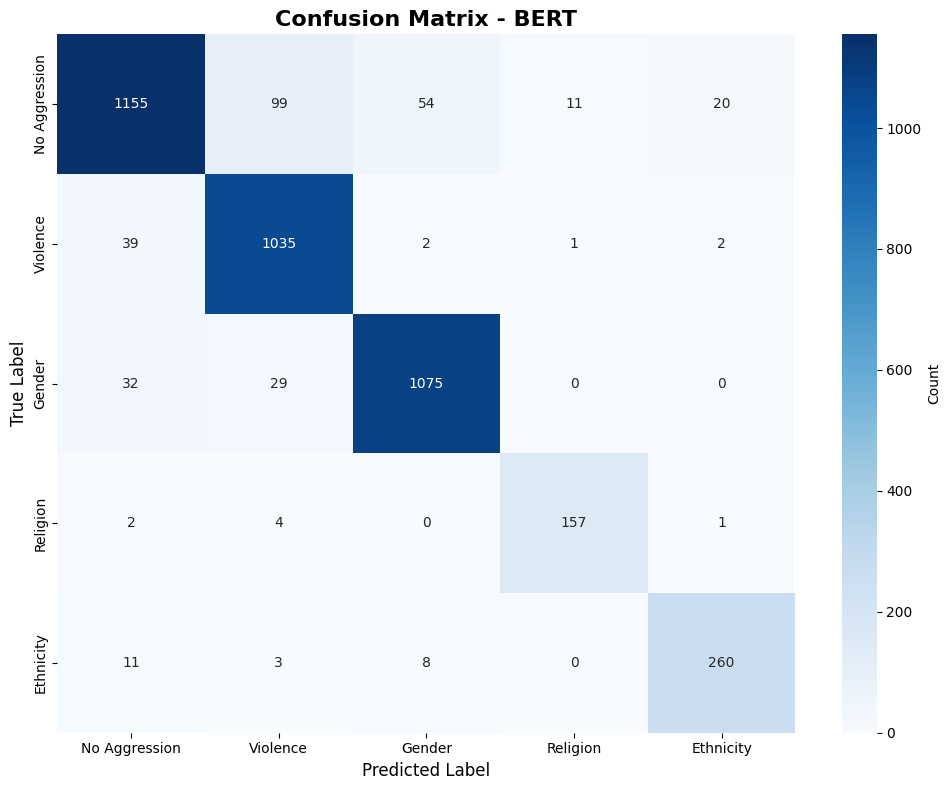

✓ Saved: confusion_matrix.png


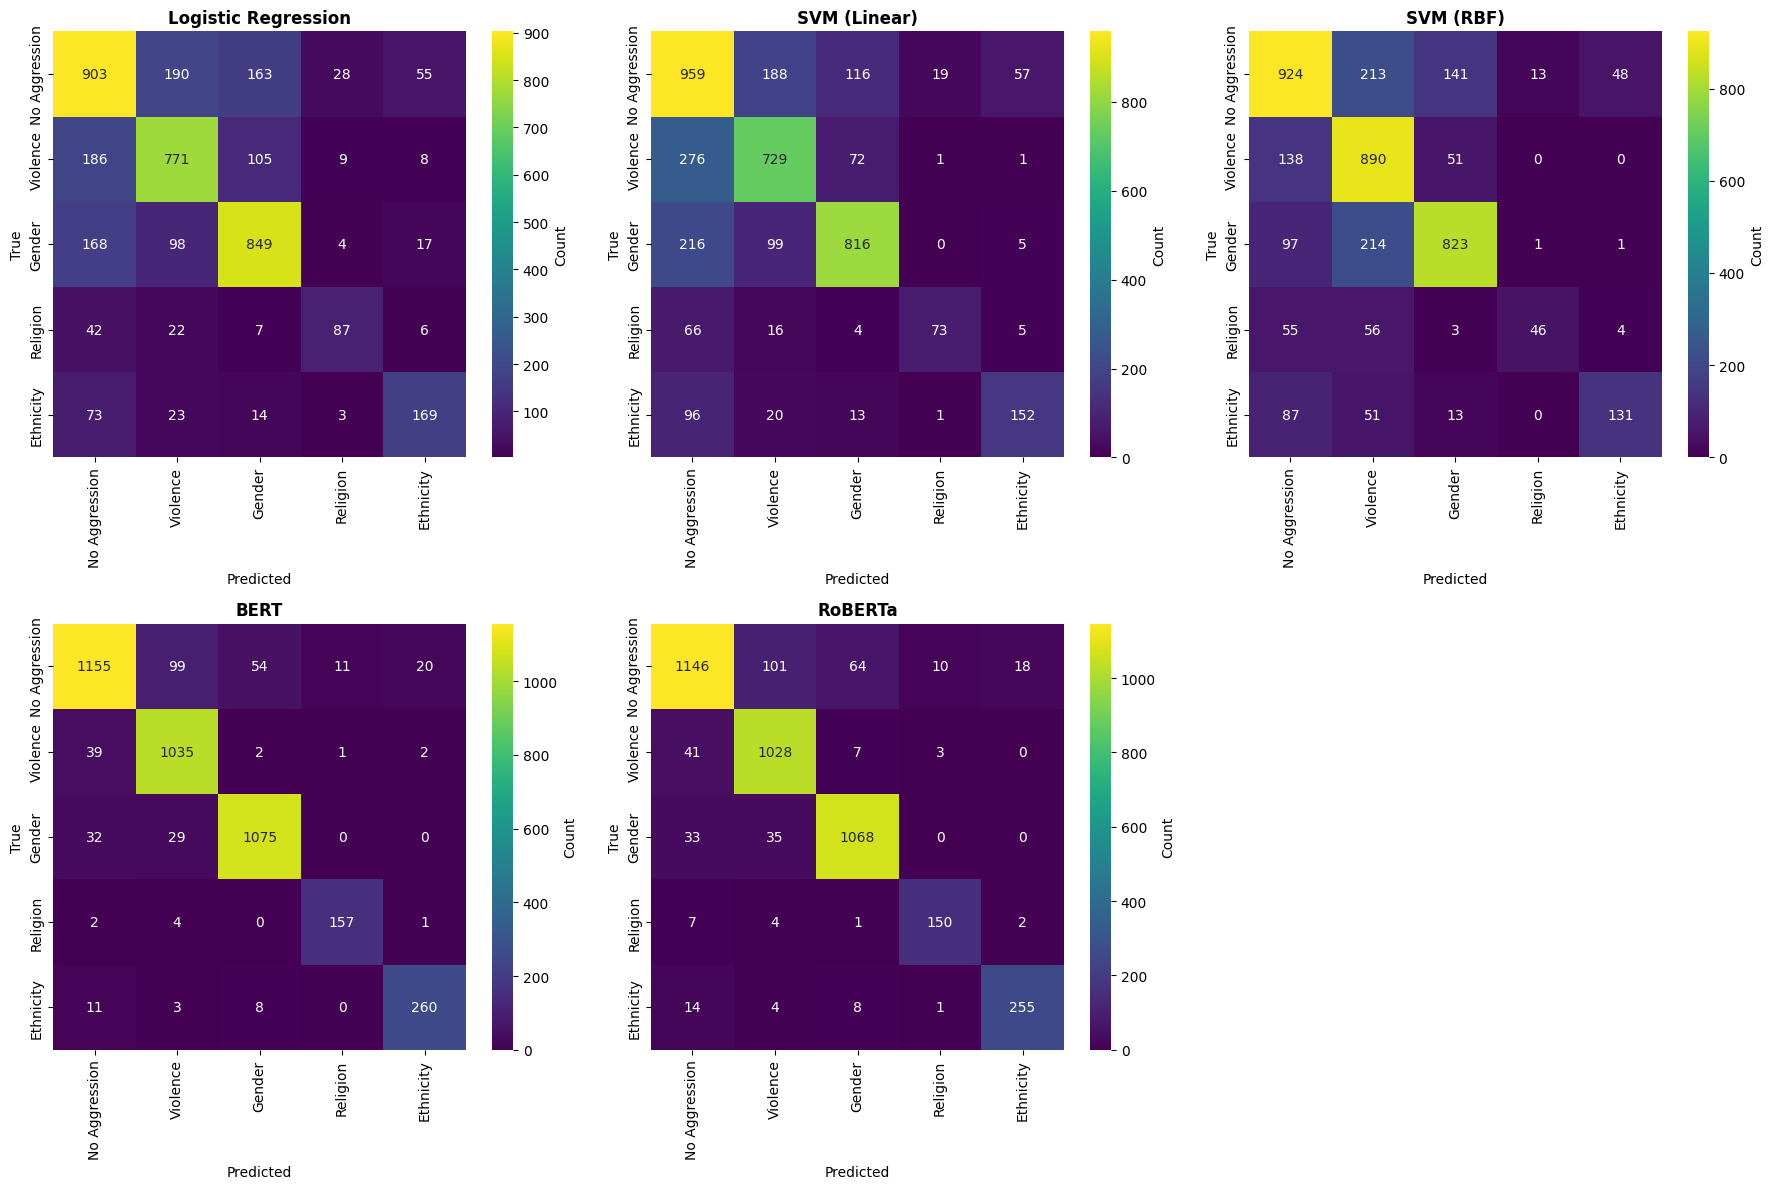

✓ Saved: all_confusion_matrices.png


In [ ]:
# ============================================================================
# SECTION A: COMPREHENSIVE MODEL EVALUATION
# ============================================================================

print("\n" + "="*80)
print("SECTION A: DETAILED MODEL EVALUATION")
print("="*80)

# Fixed: select first row's model name
best_model_name = results_df.iloc[0]['model']
print(f"\nEvaluating: {best_model_name}")

# Map model names to predictions (ensure these vars exist in scope)
model_predictions = {
    'Logistic Regression': y_pred_lr,
    'SVM (Linear)': y_pred_svm_linear,
    'SVM (RBF)': y_pred_svm_rbf,
    'BERT': y_pred_bert,
    'RoBERTa': y_pred_roberta
}

best_predictions = model_predictions[best_model_name]

print("\n" + "-"*80)
print("Classification Report - Per-Class Metrics")
print("-"*80)
report = classification_report(y_test, best_predictions, target_names=list(class_names.values()), digits=4)
print(report)

print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(y_test, best_predictions)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(class_names.values()), yticklabels=list(class_names.values()),
            cbar_kws={'label': 'Count'}, ax=ax)
ax.set_title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: confusion_matrix.png")

# Confusion matrices for all models (unchanged logic)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

all_models = [
    ('Logistic Regression', y_pred_lr),
    ('SVM (Linear)', y_pred_svm_linear),
    ('SVM (RBF)', y_pred_svm_rbf),
    ('BERT', y_pred_bert),
    ('RoBERTa', y_pred_roberta)
]

for idx, (model_name, predictions) in enumerate(all_models):
    cm_temp = confusion_matrix(y_test, predictions)
    sns.heatmap(cm_temp, annot=True, fmt='d', cmap='viridis',
                xticklabels=list(class_names.values()), yticklabels=list(class_names.values()),
                ax=axes[idx], cbar_kws={'label': 'Count'})
    axes[idx].set_title(f'{model_name}', fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')

axes[-1].axis('off')
plt.tight_layout()
plt.savefig('all_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: all_confusion_matrices.png")

PREDICTION EXAMPLES




In [ ]:
# ============================================================================
# SECTION C: REAL PREDICTION EXAMPLES (fixed probability extraction & indexing)
# ============================================================================

print("\n" + "="*80)
print("SECTION C: PREDICTION EXAMPLES (Correct & Incorrect)")
print("="*80)

# Use corrected best model selection
best_model_name = results_df.iloc[0]['model']

# Map model objects (if available) and predictions
model_objects = {
    'Logistic Regression': lr_model,
    'SVM (Linear)': svm_linear,
    'SVM (RBF)': svm_rbf,
    'BERT': model_bert if 'model_bert' in globals() else None,
    'RoBERTa': model_roberta if 'model_roberta' in globals() else None
}
model_predictions = {
    'Logistic Regression': y_pred_lr,
    'SVM (Linear)': y_pred_svm_linear,
    'SVM (RBF)': y_pred_svm_rbf,
    'BERT': y_pred_bert,
    'RoBERTa': y_pred_roberta
}

best_predictions = model_predictions[best_model_name]

# Compute probabilities robustly
if best_model_name in ['BERT', 'RoBERTa']:
    # prefer stored prediction objects if available
    logits = None
    if 'predictions_bert' in globals() and best_model_name == 'BERT':
        logits = predictions_bert.predictions
    if 'predictions_roberta' in globals() and best_model_name == 'RoBERTa':
        logits = predictions_roberta.predictions
    if logits is not None:
        probabilities = softmax(np.array(logits), axis=1)
    else:
        # fallback: create one-hot confidence for predicted class
        probabilities = np.eye(len(class_names))[best_predictions]
else:
    model_obj = model_objects.get(best_model_name)
    if model_obj is not None and hasattr(model_obj, 'predict_proba'):
        probabilities = model_obj.predict_proba(X_test)
    elif model_obj is not None and hasattr(model_obj, 'decision_function'):
        scores = model_obj.decision_function(X_test)
        if scores.ndim == 1:
            scores = np.vstack([-scores, scores]).T
        probabilities = softmax(scores, axis=1)
    else:
        probabilities = np.eye(len(class_names))[best_predictions]

# Produce flat index lists for correct/incorrect samples
correct_mask = (best_predictions == y_test)
incorrect_mask = (best_predictions != y_test)
correct_idx = np.flatnonzero(correct_mask)
incorrect_idx = np.flatnonzero(incorrect_mask)

print(f"Model: {best_model_name}")
print(f"Correct: {len(correct_idx)} | Incorrect: {len(incorrect_idx)}")

# Show up to 3 correct examples
print("\n" + "="*80)
print("✅ CORRECT PREDICTIONS")
print("="*80)
for i, idx in enumerate(correct_idx[:3], 1):
    text = test_texts[idx]
    true_label = class_names[int(y_test[idx])]
    pred_label = class_names[int(best_predictions[idx])]
    confidence = float(np.max(probabilities[idx]))
    print(f"\n{i}. EXAMPLE {i} (TEXT: {text[:80]}...)")
    print(f"   ✓ True Label:  {true_label}")
    print(f"   ✓ Predicted:   {pred_label}")
    print(f"   ✓ Confidence:  {confidence:.2%}")
    print(f"   ✓ Result:      CORRECT")

# Show up to 2 incorrect examples with basic error analysis
print("\n" + "="*80)
print("❌ INCORRECT PREDICTIONS & ANALYSIS")
print("="*80)

error_analysis = []
for i, idx in enumerate(incorrect_idx[:2], 1):
    text = test_texts[idx]
    true_label = class_names[int(y_test[idx])]
    pred_label = class_names[int(best_predictions[idx])]
    true_prob = float(probabilities[idx][int(y_test[idx])])
    pred_prob = float(np.max(probabilities[idx]))
    print(f"\n{i}. EXAMPLE {i+3} (TEXT: {text[:80]}...)")
    print(f"   ✗ True Label:  {true_label} ({true_prob:.2%})")
    print(f"   ✗ Predicted:   {pred_label} ({pred_prob:.2%})")
    print(f"   ✗ Result:      INCORRECT")
    print("\n   WHY WAS THIS WRONG?")
    reasons = []
    if len(text) < 50:
        reasons.append("   • Short text with limited context")
    if pred_prob - true_prob < 0.15:
        reasons.append("   • Model was uncertain between similar classes")
    if len(text) > 200:
        reasons.append("   • Long text with multiple topics")
    if not reasons:
        reasons = ["   • Overlapping linguistic patterns between classes", "   • Model confusion due to class similarity"]
    for reason in reasons:
        print(reason)
    error_analysis.append({
        'text_sample': text[:100],
        'true_label': true_label,
        'predicted_label': pred_label,
        'confidence_diff': pred_prob - true_prob
    })

error_df = pd.DataFrame(error_analysis)
error_df.to_csv('error_analysis.csv', index=False)
print("\n✓ Saved: error_analysis.csv")


SECTION C: PREDICTION EXAMPLES (Correct & Incorrect)
Model: BERT
Correct: 3682 | Incorrect: 318

✅ CORRECT PREDICTIONS

1. EXAMPLE 1 (TEXT: guys are made of 100% grade a bullshit...)
   ✓ True Label:  Violence
   ✓ Predicted:   Violence
   ✓ Confidence:  97.28%
   ✓ Result:      CORRECT

2. EXAMPLE 2 (TEXT: mother england and father jew..queen victoria, rothschilds brothers and benjamin...)
   ✓ True Label:  Religion
   ✓ Predicted:   Religion
   ✓ Confidence:  99.81%
   ✓ Result:      CORRECT

3. EXAMPLE 3 (TEXT: oh and fyi any jew alive at the time he said that did not kill your jeepnut unle...)
   ✓ True Label:  No Aggression
   ✓ Predicted:   No Aggression
   ✓ Confidence:  99.24%
   ✓ Result:      CORRECT

❌ INCORRECT PREDICTIONS & ANALYSIS

1. EXAMPLE 4 (TEXT: what a fake ass faggot...)
   ✗ True Label:  No Aggression (4.35%)
   ✗ Predicted:   Violence (77.00%)
   ✗ Result:      INCORRECT

   WHY WAS THIS WRONG?
   • Short text with limited context

2. EXAMPLE 5 (TEXT: hmmm? slo

TRAINING VISUALIZATION


SECTION D: TRAINING LOSS CURVES
✓ Loss history loaded


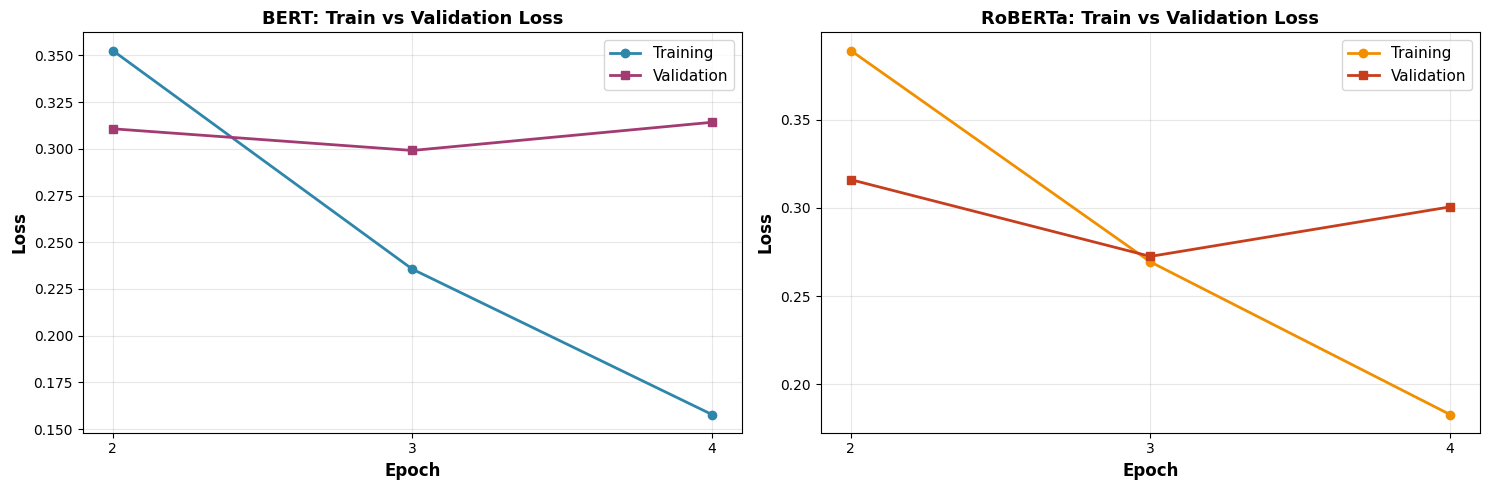

✓ Saved: individual_loss_curves.png


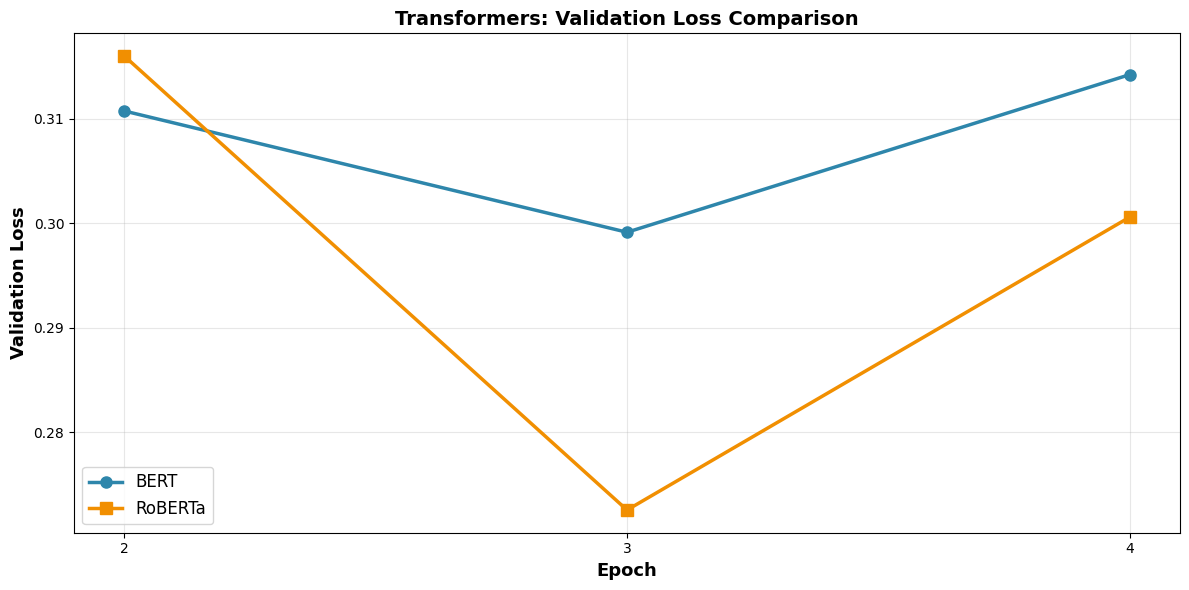

✓ Saved: validation_loss_comparison.png


In [ ]:
# ============================================================================
# SECTION D: TRAINING VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("SECTION D: TRAINING LOSS CURVES")
print("="*80)

try:
    # Load loss history
    with open('bert_loss_history.json', 'r') as f:
        bert_history = json.load(f)
    with open('roberta_loss_history.json', 'r') as f:
        roberta_history = json.load(f)

    print("✓ Loss history loaded")

    # Extract epoch-level losses for BERT
    bert_epochs = []
    bert_train_losses = []
    bert_val_losses = []
    for item in bert_history['epoch_summary']:
        if (item['train_loss'] is not None and
            item['val_loss'] is not None):  # Check both
            bert_epochs.append(int(item['epoch']) + 1)
            bert_train_losses.append(item['train_loss'])
            bert_val_losses.append(item['val_loss'])


    # Extract epoch-level losses for RoBERTa
    roberta_epochs = []
    roberta_train_losses = []
    roberta_val_losses = []
    for item in roberta_history['epoch_summary']:
        if item['train_loss'] is not None:
            roberta_epochs.append(int(item['epoch']) + 1)
            roberta_train_losses.append(item['train_loss'])
            roberta_val_losses.append(item['val_loss'])

    # Individual curves
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # BERT
    axes[0].plot(bert_epochs, bert_train_losses, 'o-', linewidth=2, label='Training', color='#2E86AB')
    axes[0].plot(bert_epochs, bert_val_losses, 's-', linewidth=2, label='Validation', color='#A23B72')
    axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[0].set_title('BERT: Train vs Validation Loss', fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xticks(bert_epochs) # Added to ensure proper tick marks

    # RoBERTa
    axes[1].plot(roberta_epochs, roberta_train_losses, 'o-', linewidth=2, label='Training', color='#F18F01')
    axes[1].plot(roberta_epochs, roberta_val_losses, 's-', linewidth=2, label='Validation', color='#C73E1D')
    axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[1].set_title('RoBERTa: Train vs Validation Loss', fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xticks(roberta_epochs) # Added to ensure proper tick marks

    plt.tight_layout()
    plt.savefig('individual_loss_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: individual_loss_curves.png")

    # Combined comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(bert_epochs, bert_val_losses, 'o-', linewidth=2.5, label='BERT', color='#2E86AB', markersize=8)
    ax.plot(roberta_epochs, roberta_val_losses, 's-', linewidth=2.5, label='RoBERTa', color='#F18F01', markersize=8)
    ax.set_xlabel('Epoch', fontsize=13, fontweight='bold')
    ax.set_ylabel('Validation Loss', fontsize=13, fontweight='bold')
    ax.set_title('Transformers: Validation Loss Comparison', fontsize=14, fontweight='bold')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(list(set(bert_epochs + roberta_epochs))) # Set common ticks for both models
    plt.tight_layout()
    plt.savefig('validation_loss_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: validation_loss_comparison.png")

except FileNotFoundError:
    print("⚠️  Loss files not found. Make sure they were saved during training.")

## CELL 10: Visualize & Summarize Results

In [ ]:
print("\n" + "="*80)
print("="*80)


for idx, row in results_df.iterrows():
    rank = idx + 1
    model_name = row['model']
    accuracy = row['accuracy']
    f1 = row['f1_weighted']

    print(f"{rank}. {model_name:25s} | Accuracy: {accuracy:6.1%} | F1: {f1:6.1%}")



print("\n" + "="*80)
print("✅ MODEL TRAINING COMPLETE!")
print("="*80)
print(f"\nOutput files created:")
print(f"  ✓ model_comparison_results.csv")
print(f"  ✓ training_results.json")
print(f"  ✓ ./models/bert_model/ (saved BERT)")
print(f"  ✓ ./models/roberta_model/ (saved RoBERTa)")
print(f"  ✓ ./logs/ (training logs)")


1. BERT                      | Accuracy:  92.0% | F1:  92.0%
2. RoBERTa                   | Accuracy:  91.2% | F1:  91.1%
3. SVM (RBF)                 | Accuracy:  70.3% | F1:  69.8%
4. Logistic Regression       | Accuracy:  69.5% | F1:  69.4%
5. SVM (Linear)              | Accuracy:  68.2% | F1:  68.3%

✅ MODEL TRAINING COMPLETE!

Output files created:
  ✓ model_comparison_results.csv
  ✓ training_results.json
  ✓ ./models/bert_model/ (saved BERT)
  ✓ ./models/roberta_model/ (saved RoBERTa)
  ✓ ./logs/ (training logs)


In [ ]:
pip install bertviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.4 MB/s eta 0:00:00


In [ ]:
# Add this cell before the Analysis/LIME sections
classnames = class_names
ytest = y_test
ypredbert = y_pred_bert
modelbert = model_bert
tokenizerbert = tokenizer_bert

In [ ]:
!pip install -q shap lime captum transformers-interpret


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.6 MB/s eta 0:00:00


In [ ]:
import subprocess
import sys

packages = ['lime', 'shap', 'bertviz', 'captum', 'matplotlib', 'seaborn']
for pkg in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])


Add Model Comparison Analysis

In [ ]:
# ============================================================
# PHASE 1B: MODEL COMPARISON - WHERE DO MODELS DISAGREE?
# ============================================================
print("\n" + "="*80)
print("MODEL DISAGREEMENT ANALYSIS")
print("="*80)

# Compare predictions
pred_matrix = np.array([
    y_pred_bert, y_pred_roberta, y_pred_lr, y_pred_svm_linear, y_pred_svm_rbf
])
model_names = ['BERT', 'RoBERTa', 'LR', 'SVM-Linear', 'SVM-RBF']

# Compute pairwise agreement
print("\nPairwise Model Agreement:")
agreement_matrix = np.zeros((len(model_names), len(model_names)))

for i in range(len(model_names)):
    for j in range(len(model_names)):
        if i != j:
            agreement = np.mean(pred_matrix[i] == pred_matrix[j])
            agreement_matrix[i, j] = agreement
            print(f"  {model_names[i]:12} vs {model_names[j]:12}: {agreement:.1%}")

# Find disagreement samples (useful for debugging)
all_agree = np.all([pred == pred_matrix for pred in pred_matrix], axis=0)
disagreement_idx = np.where(~all_agree)[0] # Added [0] to get the actual indices

print(f"\nModels agree on {np.sum(all_agree)}/{len(ytest)} samples ({np.sum(all_agree)/len(ytest)*100:.1f}%)")
print(f"Models disagree on {len(disagreement_idx)} samples")

# Analyze disagreement samples
print("\nSample disagreements (first 3):")
for idx in disagreement_idx[:3]:
    print(f"\n  Sample {idx}: {test_texts[idx][:70]}...")
    for model_idx, model_name in enumerate(model_names):
        pred = pred_matrix[model_idx, idx]
        print(f"    {model_name:12} → {classnames[pred]}")
    print(f"    True label  → {classnames[ytest[idx]]}")

# Save disagreement analysis
disagreement_data = [{
    'idx': int(idx),
    'text': test_texts[idx],
    'true': classnames[ytest[idx]],
    'predictions': {name: classnames[pred_matrix[i, idx]]
                   for i, name in enumerate(model_names)}
} for idx in disagreement_idx[:20]]

with open('phase1_disagreement_analysis.json', 'w') as f:
    json.dump(disagreement_data, f, indent=2)
print(f"✓ Saved: phase1_disagreement_analysis.json")



MODEL DISAGREEMENT ANALYSIS

Pairwise Model Agreement:
  BERT         vs RoBERTa     : 95.1%
  BERT         vs LR          : 70.2%
  BERT         vs SVM-Linear  : 68.7%
  BERT         vs SVM-RBF     : 72.2%
  RoBERTa      vs BERT        : 95.1%
  RoBERTa      vs LR          : 69.8%
  RoBERTa      vs SVM-Linear  : 69.0%
  RoBERTa      vs SVM-RBF     : 72.1%
  LR           vs BERT        : 70.2%
  LR           vs RoBERTa     : 69.8%
  LR           vs SVM-Linear  : 79.8%
  LR           vs SVM-RBF     : 74.1%
  SVM-Linear   vs BERT        : 68.7%
  SVM-Linear   vs RoBERTa     : 69.0%
  SVM-Linear   vs LR          : 79.8%
  SVM-Linear   vs SVM-RBF     : 72.2%
  SVM-RBF      vs BERT        : 72.2%
  SVM-RBF      vs RoBERTa     : 72.1%
  SVM-RBF      vs LR          : 74.1%
  SVM-RBF      vs SVM-Linear  : 72.2%

Models agree on 10580/4000 samples (264.5%)
Models disagree on 9420 samples

Sample disagreements (first 3):

  Sample 0: guys are made of 100% grade a bullshit...
    BERT         → 

Add Token Saliency Analysis

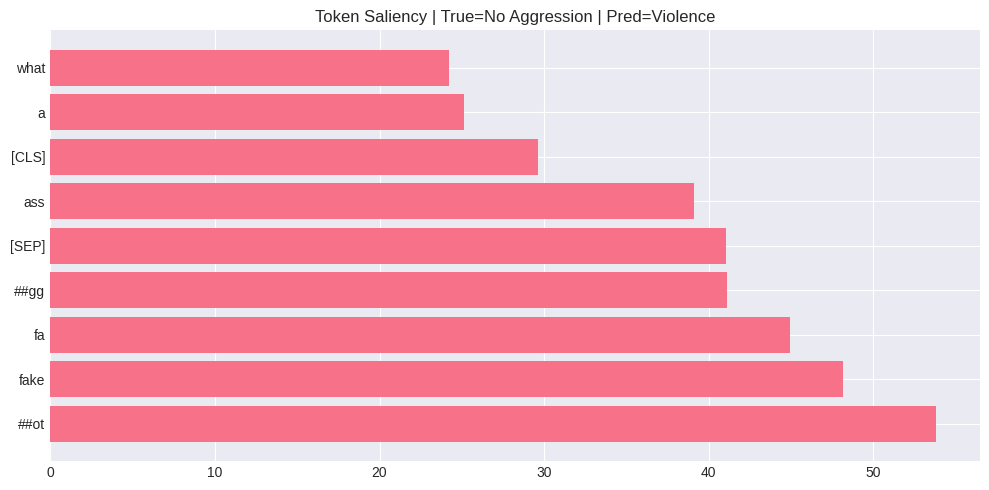

In [ ]:
# ============================================================
# PHASE 1: TOKEN SALIENCY (Gradient-based)
# ============================================================

import torch
import numpy as np
import matplotlib.pyplot as plt

def compute_token_saliency(text, model, tokenizer, target_class=None, device='cuda'):

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=256
    ).to(device)

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    token_type_ids = inputs.get("token_type_ids", None)

    # Get the raw token embeddings from the model's embedding layer
    embeddings = model.get_input_embeddings()(input_ids)

    # Fix: Detach embeddings to make them a leaf variable, then set requires_grad=True
    embeddings = embeddings.detach().requires_grad_(True)

    # Pass these embeddings (and other relevant inputs) to the model's forward method
    # Use inputs_embeds argument to bypass the internal embedding lookup
    outputs = model(
        inputs_embeds=embeddings,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
    )
    logits = outputs.logits

    if target_class is None:
        target_class = torch.argmax(logits, dim=1).item()

    # Compute gradients of the target logit with respect to the embeddings
    model.zero_grad() # Clear any existing gradients
    target_logit = logits[0, target_class]
    target_logit.backward() # Compute gradients

    # Extract saliency scores. The gradients are on the embedding vectors.
    # Sum absolute gradients across the embedding dimension to get a scalar saliency for each token
    grads = embeddings.grad.abs().sum(dim=-1).detach().cpu().numpy().flatten()

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    return grads, tokens, logits.softmax(dim=1).detach().cpu().numpy()


# ---- RUN SALIENCY ON FIRST MISCLASSIFIED SAMPLE ----

for i in range(len(test_texts)):
    if y_test[i] != y_pred_bert[i]:
        sample_idx = i
        break

text = test_texts[sample_idx]
true_label = classnames[y_test[sample_idx]]
pred_label = classnames[y_pred_bert[sample_idx]]

saliency, tokens, probs = compute_token_saliency(text, model_bert, tokenizer_bert)

top_k = 10
top_idx = np.argsort(saliency)[-top_k:][::-1]

plt.figure(figsize=(10,5))
plt.barh([tokens[i] for i in top_idx], saliency[top_idx])
plt.title(f"Token Saliency | True={true_label} | Pred={pred_label}")
plt.tight_layout()
plt.savefig("token_saliency.png", dpi=300)
plt.show()

Attention Visualization


Showing attention for (misclassified sample):
what a fake ass faggot

True: No Aggression
Pred: Violence

Launching BertViz head view...


<IPython.core.display.Javascript object>

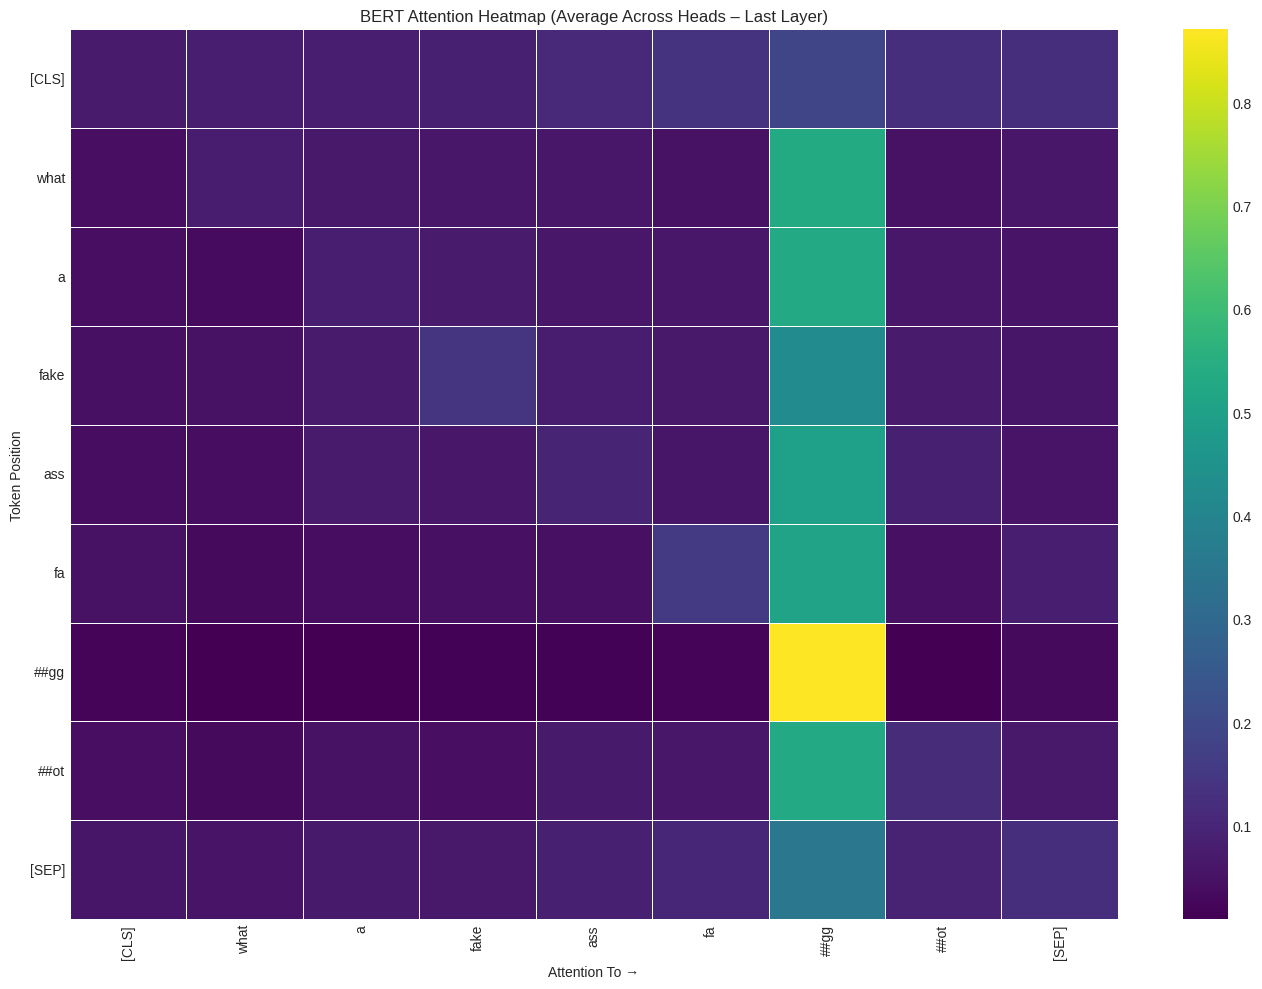


✓ Attention heatmap generated.


In [ ]:
# ============================================================
# PHASE 4: ADVANCED ATTENTION VISUALIZATION (BERTVIZ + HEATMAP)
# ============================================================

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bertviz import head_view
from google.colab import output
output.enable_custom_widget_manager()

# Pick a misclassified sample
wrong = np.where(ypredbert != ytest)[0]
sample_idx = int(wrong[0]) if len(wrong) > 0 else 0
text = test_texts[sample_idx]

print("\nShowing attention for (misclassified sample):")
print(text)
print("\nTrue:", classnames[ytest[sample_idx]])
print("Pred:", classnames[ypredbert[sample_idx]])

# ------------------------------------------------------------
# TOKENIZATION
# ------------------------------------------------------------
inputs = tokenizerbert(text, return_tensors="pt")
tokens = tokenizerbert.convert_ids_to_tokens(inputs["input_ids"][0])

# Move model to CPU (bertviz cannot use GPU tensors)
modelbert_cpu = modelbert.cpu()

# Forward pass with attention extraction
with torch.no_grad():
    outputs = modelbert_cpu(**inputs, output_attentions=True)

attentions = outputs.attentions  # tuple: [num_layers][batch, heads, seq, seq]

# ------------------------------------------------------------
# BERTVIZ interactive view (per-head attention)
# ------------------------------------------------------------
print("\nLaunching BertViz head view...")
head_view(attentions, tokens)


# ============================================================
# ATTENTION HEATMAP (AVERAGED ACROSS ALL HEADS)
# ============================================================

# Average attention across:
#   • batch dimension
#   • all heads
#   • optionally all layers (we pick last layer for clarity)

last_layer_attention = attentions[-1]          # shape: (1, heads, seq, seq)
avg_attention = last_layer_attention.mean(dim=1)[0].numpy()  # (seq, seq)

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    avg_attention,
    xticklabels=tokens,
    yticklabels=tokens,
    cmap="viridis",
    linewidths=0.5
)

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("BERT Attention Heatmap (Average Across Heads – Last Layer)")
plt.xlabel("Attention To →")
plt.ylabel("Token Position")
plt.tight_layout()
plt.show()

print("\n✓ Attention heatmap generated.")


Error Analysis Report

In [ ]:
# ============================================================
# PHASE 3B: COMPREHENSIVE ERROR ANALYSIS (WITH EXPLANATION)
# ============================================================
print("\n" + "="*80)
print("PHASE 3B: ERROR PATTERN ANALYSIS")
print("="*80)

# Categorize errors
errors = []

# ------------------------------------------------------------------------------
# 1. Ensure probabilities exist
# ------------------------------------------------------------------------------
if 'probabilities' not in globals():
    if 'predictions_bert' in globals():
        probabilities = softmax(predictions_bert.predictions, axis=1)
    else:
        print("Warning: 'predictions_bert' missing. Creating dummy uniform probabilities.")
        probabilities = np.ones((len(y_test), len(classnames))) / len(classnames)

# ------------------------------------------------------------------------------
# 2. Identify misclassified samples and collect error attributes
# ------------------------------------------------------------------------------
mis_idx = np.where(ypredbert != ytest)[0]

for idx in mis_idx:
    text = test_texts[idx]
    true_label = classnames[ytest[idx]]
    pred_label = classnames[ypredbert[idx]]
    confidence = probabilities[idx][ypredbert[idx]]

    # Define error types:
    # - "uncertain" → model low confidence (<0.6)
    # - "confident_wrong" → high confidence but still wrong
    error_type = "uncertain" if confidence < 0.6 else "confident_wrong"

    errors.append({
        'idx': int(idx),
        'text': text,
        'true': true_label,
        'predicted': pred_label,
        'error_type': error_type,
        'text_length': len(text.split()),
        'confidence': float(confidence)
    })

# ------------------------------------------------------------------------------
# 3. Aggregate and report
# ------------------------------------------------------------------------------
error_df = pd.DataFrame(errors)
print("\nError Statistics:")
print(f"  Total errors: {len(error_df)}")
print(f"  Uncertain errors: {len(error_df[error_df['error_type'] == 'uncertain'])}")
print(f"  Confident errors: {len(error_df[error_df['error_type'] == 'confident_wrong'])}")
print(f"  Average text length: {error_df['text_length'].mean():.1f} words")

# ------------------------------------------------------------------------------
# 4. Explanation of Error Patterns
# ------------------------------------------------------------------------------
print("\n--- EXPLANATION OF ERROR PATTERNS ---")

print("\n1. UNCERTAIN ERRORS (<0.6 confidence):")
print("   These represent cases where the model was unsure, meaning the text")
print("   likely contains:")
print("   • Ambiguous aggression indicators")
print("   • Mixed or indirect aggression (e.g., sarcasm, coded language)")
print("   • Short or incomplete context")
print("   These errors suggest the model struggles when cues for aggression")
print("   are subtle, spread out, or implicit.")

print("\n2. CONFIDENT WRONG ERRORS (>0.6 confidence):")
print("   These are more important for explainable AI because the model is")
print("   strongly convinced *but still wrong*. This often occurs when:")
print("   • Spurious correlations drive the prediction")
print("   • Certain words are overly influential (bias patterns)")
print("   • Model overfits aggressive keywords without context")
print("   • Another class has overlapping linguistic characteristics")
print("   These errors are the best candidates for SHAP/LIME analysis.")

print("\n3. TEXT LENGTH EFFECTS:")
print("   Longer texts provide more contextual cues and usually reduce")
print("   uncertainty. However, they may introduce noise when multiple topics")
print("   appear in the same text. Short texts rely heavily on individual")
print("   words, which may cause misclassification if those words resemble")
print("   aggressive vocabulary from training.")

print("\n4. Overall Interpretation:")
print("   By separating confident vs. uncertain errors, we can understand:")
print("   • Whether failures come from ambiguity or model bias")
print("   • Where explainability tools should be applied (high-confidence wrong)")
print("   • Whether additional preprocessing (slang normalization, context")
print("     expansion) is needed to reduce uncertain errors.")
print("   • Whether class imbalance or keyword dominance affects predictions.")

# ------------------------------------------------------------------------------
# 5. Save detailed report
# ------------------------------------------------------------------------------
error_df.to_csv('phase3_error_analysis.csv', index=False)
print("\n✓ Saved: phase3_error_analysis.csv")



PHASE 3B: ERROR PATTERN ANALYSIS

Error Statistics:
  Total errors: 318
  Uncertain errors: 36
  Confident errors: 282
  Average text length: 14.0 words

--- EXPLANATION OF ERROR PATTERNS ---

1. UNCERTAIN ERRORS (<0.6 confidence):
   These represent cases where the model was unsure, meaning the text
   likely contains:
   • Ambiguous aggression indicators
   • Mixed or indirect aggression (e.g., sarcasm, coded language)
   • Short or incomplete context
   These errors suggest the model struggles when cues for aggression
   are subtle, spread out, or implicit.

2. CONFIDENT WRONG ERRORS (>0.6 confidence):
   These are more important for explainable AI because the model is
   strongly convinced *but still wrong*. This often occurs when:
   • Spurious correlations drive the prediction
   • Certain words are overly influential (bias patterns)
   • Model overfits aggressive keywords without context
   • Another class has overlapping linguistic characteristics
   These errors are the best 

LIME & SHAP Implementation

In [ ]:
# 1) Imports
import os, json, math, time
import numpy as np
import torch
from IPython.display import HTML, display
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
import shap
from lime.lime_text import LimeTextExplainer

# 2) Class names (from your message)
class_names = {
    0: "No Aggression",
    1: "Violence",
    2: "Gender",
    3: "Religion",
    4: "Ethnicity"
}
num_classes = len(class_names)

# 3) Helper: find models/tokenizers in globals (common names)
models_to_explain = []  # list of tuples: (label, model_obj, tokenizer_obj, shortname)
global_vars = globals()

# Common names mapping - adjust if your notebook uses different names
candidates = [
    ("BERT", "model_bert", "tokenizer_bert"),
    ("BERT", "model_bert", "tokenizer"),
    ("RoBERTa", "model_roberta", "tokenizer_roberta"),
    ("RoBERTa", "model_roberta", "tokenizer"),
    ("Transformer", "model", "tokenizer"),
]

for label, mname, tname in candidates:
    if mname in global_vars and tname in global_vars:
        models_to_explain.append((label, global_vars[mname], global_vars[tname], mname))

if not models_to_explain:
    raise RuntimeError("No transformer models/tokenizers found in globals(). "
                       "Ensure variables like model_bert + tokenizer_bert or model_roberta + tokenizer_roberta exist.")

# 4) Ensure test_texts and y_test present
if 'test_texts' not in global_vars:
    raise RuntimeError("`test_texts` not found in globals(). Provide a list of test strings.")
if 'y_test' not in global_vars:
    raise RuntimeError("`y_test` not found in globals(). Provide ground-truth labels array/list for test_texts.")

test_texts = global_vars['test_texts']
y_test = np.array(global_vars['y_test'])

# 5) Device setup
if 'device' in global_vars:
    device = global_vars['device']
else:
    device = ('cuda' if torch.cuda.is_available() else 'cpu')
torch_device = torch.device(device)

# 6) Output folders
out_dir = "xai_outputs"
os.makedirs(out_dir, exist_ok=True)
os.makedirs(os.path.join(out_dir, "shap_html"), exist_ok=True)
os.makedirs(os.path.join(out_dir, "lime_html"), exist_ok=True)
os.makedirs(os.path.join(out_dir, "saliency_png"), exist_ok=True)


In [ ]:
# 7) Utility functions
def visualize_saliency_html(tokens, scores, title=None):
    # normalize
    arr = np.array(scores, dtype=float)
    if arr.max() - arr.min() < 1e-9:
        norm = np.zeros_like(arr)
    else:
        norm = (arr - arr.min()) / (arr.max() - arr.min() + 1e-9)
    html = ""
    if title:
        html += f"<div style='font-weight:bold;margin-bottom:6px'>{title}</div>"
    for t, s in zip(tokens, norm):
        # escape HTML in token
        t_safe = (t.replace(" ", "&nbsp;")).replace("<", "&lt;").replace(">", "&gt;")
        html += f"<span style='background-color: rgba(255,0,0,{s}); padding:3px; margin:2px; border-radius:3px'>{t_safe}</span> "
    return HTML(html)

def save_html(content, filename):
    with open(filename, "w", encoding="utf-8") as f:
        f.write(content)

# 8) Prediction wrappers (safe)
def make_predict_proba_fn(model, tokenizer):
    model.to(torch_device)
    model.eval()
    def predict_proba(texts):
        # ensure list
        if isinstance(texts, str):
            texts = [texts]
        if isinstance(texts, np.ndarray):
            texts = texts.tolist()
        # tokenizer returns tensors
        inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        # move to device
        inputs = {k: v.to(torch_device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()
        return probs
    return predict_proba

In [ ]:
# 9) SHAP: correct masker & explainer usage (text masker)
def run_shap_on_texts(model, tokenizer, texts, save_prefix, max_samples=10):
    """
    texts: list of strings (length <= max_samples)
    returns: shap_values object
    """
    model.to(torch_device)
    model.eval()

    # Prepare prediction fn
    pred_fn = make_predict_proba_fn(model, tokenizer)
    # Use a Text masker so tokens align with tokenizer
    try:
        masker = shap.maskers.Text(tokenizer)  # shap v0.41+ supports Text masker
        explainer = shap.Explainer(pred_fn, masker, output_names=[class_names[i] for i in sorted(class_names.keys())])
    except Exception as e:
        # fallback to Explainer with tokenizer directly (less ideal)
        print("Warning: shap.maskers.Text not available or failed - fallback explainer used:", e)
        explainer = shap.Explainer(pred_fn, tokenizer)

    # Limit samples
    texts = texts[:max_samples]
    shap_values = explainer(texts)

    # Save HTML visualizations for each sample
    for i, t in enumerate(texts):
        try:
            html = shap.plots.text(shap_values[i], display=False)
            # shap.plots._text returns HTML; convert to str if necessary
            fname = os.path.join(out_dir, "shap_html", f"{save_prefix}_sample{i}.html")
            if isinstance(html, str):
                save_html(html, fname)
            else:
                # try __html__ or str
                try:
                    save_html(html.__html__(), fname)
                except Exception:
                    # fallback to saving a simple text summary
                    save_html(f"<pre>{str(shap_values[i])}</pre>", fname)
            print(f"Saved SHAP HTML: {fname}")
        except Exception as ex:
            print(f"Could not render/save SHAP for sample {i}: {ex}")

    return shap_values

In [ ]:
# 10) Integrated Gradients + token saliency
def token_gradient_saliency(text, model, tokenizer, target_class=None):
    model.to(torch_device)
    model.eval()
    # encode
    encoding = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(torch_device) for k, v in encoding.items()}
    input_ids = inputs["input_ids"]
    attention_mask = inputs.get("attention_mask", None)

    # get embeddings layer
    emb_layer = model.get_input_embeddings()
    # inputs_embeds for gradient calculation
    inputs_embeds = emb_layer(input_ids)
    inputs_embeds = inputs_embeds.clone().detach().requires_grad_(True)

    kwargs = {}
    if attention_mask is not None:
        kwargs['attention_mask'] = attention_mask

    outputs = model(inputs_embeds=inputs_embeds, **kwargs)
    logits = outputs.logits
    probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()

    if target_class is None:
        target_class_idx = int(torch.argmax(logits, dim=-1).item())
    else:
        target_class_idx = int(target_class)

    # backward on chosen logit
    model.zero_grad()
    logit_target = logits[0, target_class_idx]
    logit_target.backward(retain_graph=True)
    grads = inputs_embeds.grad.abs().squeeze(0).sum(dim=-1).detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    return grads, tokens, probs

def integrated_gradients_attribution(text, model, tokenizer, n_steps=50):
    model.to(torch_device)
    model.eval()
    # wrapper forward for embeddings
    def forward_embs(inputs_embeds, attention_mask):
        out = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
        return out.logits

    encoding = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(torch_device) for k, v in encoding.items()}
    input_ids = inputs["input_ids"]
    attention_mask = inputs.get("attention_mask", None)
    emb_layer = model.get_input_embeddings()
    input_embeds = emb_layer(input_ids)
    ig = IntegratedGradients(forward_embs)
    attributions = ig.attribute(input_embeds, additional_forward_args=(attention_mask,), n_steps=n_steps)
    token_attr = attributions.squeeze().sum(dim=-1).detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    return token_attr, tokens


In [ ]:
# 11) LIME: stable wrapper
lime_explainer = LimeTextExplainer(class_names=[class_names[i] for i in sorted(class_names.keys())], split_expression=True, bow=False)

def run_lime_for_sample(text, model, tokenizer, save_prefix, num_features=10, num_samples=100):
    predict_proba = make_predict_proba_fn(model, tokenizer)
    try:
        exp = lime_explainer.explain_instance(text, predict_proba, num_features=num_features, num_samples=num_samples, top_labels=1)
        fname = os.path.join(out_dir, "lime_html", f"{save_prefix}.html")
        # save HTML; Lime's HTML export
        try:
            exp.save_to_file(fname)
            print(f"Saved LIME HTML: {fname}")
        except Exception:
            # fallback: save as JSON
            simple = {"as_list": exp.as_list(), "local_pred": exp.predict_proba}
            with open(fname.replace(".html", ".json"), "w", encoding="utf-8") as f:
                json.dump(simple, f, indent=2)
            print(f"Saved LIME JSON fallback: {fname.replace('.html', '.json')}")
        return exp
    except Exception as ex:
        print("LIME explanation failed:", ex)
        return None


In [ ]:
# 12) Runner: for each model, run SHAP (10 samples), LIME (5 misclassified), IG+saliency (same samples)
summary = {"models": {}, "run_time": time.asctime()}

# get predictions if present (common names)
# Try to locate predictions arrays for transformer models; fallbacks: y_pred_bert, y_pred_roberta, y_pred
global_preds = {}
if 'y_pred_bert' in global_vars:
    global_preds['BERT'] = np.array(global_vars['y_pred_bert'])
if 'y_pred_roberta' in global_vars:
    global_preds['RoBERTa'] = np.array(global_vars['y_pred_roberta'])
if 'y_pred' in global_vars:
    global_preds['Transformer'] = np.array(global_vars['y_pred'])

for label, model_obj, tokenizer_obj, shortname in models_to_explain:
    print("\n" + "="*80)
    print(f"Running XAI for model: {label} (variable name: {shortname})")
    print("="*80)
    try:
        # SHAP on first 10 test samples (or less)
        n_shap = 10
        sample_texts = test_texts[:n_shap]
        shap_vals = run_shap_on_texts(model_obj, tokenizer_obj, sample_texts, save_prefix=shortname, max_samples=n_shap)

        # LIME on first 5 misclassified samples (if predictions available)
        preds = global_preds.get(label, None)
        lime_results = []
        if preds is not None:
            mis_idx = np.where(preds != y_test)[0][:5].tolist()
        else:
            # If no preds, just use first 5 samples
            mis_idx = list(range(min(5, len(test_texts))))

        for mi in mis_idx:
            txt = test_texts[mi]
            exp = run_lime_for_sample(txt, model_obj, tokenizer_obj, save_prefix=f"{shortname}_idx{mi}", num_features=10, num_samples=100)
            if exp:
                lime_results.append({"idx": int(mi), "as_list": exp.as_list()})
        # IG and gradient saliency for sample set (shap samples)
        ig_results = []
        for i, t in enumerate(sample_texts):
            try:
                grads, toks, probs = token_gradient_saliency(t, model_obj, tokenizer_obj)
                ig_attr, ig_tokens = integrated_gradients_attribution(t, model_obj, tokenizer_obj, n_steps=50)
                # save PNG bar chart of top tokens by grads
                topk = min(12, len(toks))
                top_idx = np.argsort(grads)[-topk:][::-1]
                fig, ax = plt.subplots(figsize=(8, max(2, topk*0.35)))
                ax.barh([ig_tokens[j] for j in top_idx[::-1]], grads[top_idx[::-1]])
                ax.set_title(f"{label} Saliency (sample {i})")
                plt.tight_layout()
                pngfile = os.path.join(out_dir, "saliency_png", f"{shortname}_sample{i}.png")
                fig.savefig(pngfile, dpi=200)
                plt.close(fig)
                ig_results.append({"sample": i, "png": pngfile, "top_tokens": [ig_tokens[j] for j in top_idx.tolist()]})
            except Exception as e:
                print(f"IG/Saliency error for sample {i}: {e}")
        # Save model entry
        summary["models"][label] = {
            "shortname": shortname,
            "shap_html_files": [os.path.join(out_dir, "shap_html", f"{shortname}_sample{i}.html") for i in range(min(n_shap, len(test_texts)))],
            "lime_results": lime_results,
            "ig_results": ig_results
        }
    except Exception as e:
        print(f"Top-level XAI failure for model {label}: {e}")



Running XAI for model: BERT (variable name: model_bert)


PartitionExplainer explainer: 11it [00:16,  5.40s/it]


Saved SHAP HTML: xai_outputs/shap_html/model_bert_sample0.html
Saved SHAP HTML: xai_outputs/shap_html/model_bert_sample1.html
Saved SHAP HTML: xai_outputs/shap_html/model_bert_sample2.html
Saved SHAP HTML: xai_outputs/shap_html/model_bert_sample3.html
Saved SHAP HTML: xai_outputs/shap_html/model_bert_sample4.html
Saved SHAP HTML: xai_outputs/shap_html/model_bert_sample5.html
Saved SHAP HTML: xai_outputs/shap_html/model_bert_sample6.html
Saved SHAP HTML: xai_outputs/shap_html/model_bert_sample7.html
Saved SHAP HTML: xai_outputs/shap_html/model_bert_sample8.html
Saved SHAP HTML: xai_outputs/shap_html/model_bert_sample9.html
Saved LIME HTML: xai_outputs/lime_html/model_bert_idx1.html
Saved LIME HTML: xai_outputs/lime_html/model_bert_idx17.html
Saved LIME HTML: xai_outputs/lime_html/model_bert_idx61.html
Saved LIME HTML: xai_outputs/lime_html/model_bert_idx67.html
Top-level XAI failure for model BERT: 1

Running XAI for model: RoBERTa (variable name: model_roberta)


PartitionExplainer explainer: 11it [00:13,  4.45s/it]


Saved SHAP HTML: xai_outputs/shap_html/model_roberta_sample0.html
Saved SHAP HTML: xai_outputs/shap_html/model_roberta_sample1.html
Saved SHAP HTML: xai_outputs/shap_html/model_roberta_sample2.html
Saved SHAP HTML: xai_outputs/shap_html/model_roberta_sample3.html
Saved SHAP HTML: xai_outputs/shap_html/model_roberta_sample4.html
Saved SHAP HTML: xai_outputs/shap_html/model_roberta_sample5.html
Saved SHAP HTML: xai_outputs/shap_html/model_roberta_sample6.html
Saved SHAP HTML: xai_outputs/shap_html/model_roberta_sample7.html
Saved SHAP HTML: xai_outputs/shap_html/model_roberta_sample8.html
Saved SHAP HTML: xai_outputs/shap_html/model_roberta_sample9.html
Saved LIME HTML: xai_outputs/lime_html/model_roberta_idx1.html
Saved LIME HTML: xai_outputs/lime_html/model_roberta_idx17.html
Saved LIME HTML: xai_outputs/lime_html/model_roberta_idx28.html
Saved LIME HTML: xai_outputs/lime_html/model_roberta_idx34.html
Saved LIME HTML: xai_outputs/lime_html/model_roberta_idx42.html
Top-level XAI failure

In [ ]:
# 13) Save summary JSON
summary_path = os.path.join(out_dir, "XAI_results_summary.json")
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)
print("\nSaved overall XAI summary:", summary_path)

# Done
print("\nXAI pipeline finished. Inspect the files in the xai_outputs/ folder for HTML, PNG and JSON results.")


Saved overall XAI summary: xai_outputs/XAI_results_summary.json

XAI pipeline finished. Inspect the files in the xai_outputs/ folder for HTML, PNG and JSON results.
